# Multiclass (multinomial) classifiers
Multiclass classifiers are capable of distinguishing among multiple classes. Many classifiers are basically binary classifiers that are adapted to work with multiple classes using one of the following strategies:

## One-versus-all (OvA)
We train a specialized binary classifier for each of the classes and we choose the class associated with the classifier with the best score.

## One-versus-one (OvO)
We train a binary classifiers for each pair of classes in opposition and we choose the class winning the highest number of duels.

When we use a binary classifier for a multiclass problem with sklearn, the most suitable solution is adopted automatically.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing as pre
from sklearn.model_selection import train_test_split

In [2]:
file = '../data/classification.xlsx'
D = pd.read_excel(file)

In [3]:
D.dropna(inplace=True)

## Remove largest class

In [64]:
D = D[D['dependent variable'] != 'cancellato senza alcuna ragione di cancellazione']

## Preprocessing

In [65]:
target = 'dependent variable'
X, target_values = D[[x for x in D.columns if x != target]], D[target].values
encoder = pre.OrdinalEncoder()
y = encoder.fit_transform(target_values.reshape(-1, 1))
S_train, S_test, s_train, s_test = train_test_split(X, y, stratify=X.category, test_size=0.2, random_state=42)
categories = dict((i, n) for i, n in enumerate(encoder.categories_[0]))

## Example with a single variable vs multiclasses

In [66]:
from sklearn.model_selection import cross_val_score, cross_val_predict
import sklearn.metrics as mx

In [67]:
variable = 'macrocategory_name'

In [68]:
hot = pre.OneHotEncoder(sparse=False)
H_train = hot.fit_transform(S_train[[variable]].values.reshape(-1, 1))
H_test = hot.fit_transform(S_test[[variable]].values.reshape(-1, 1))

In [69]:
def train_and_test(classifiers, x_train, y_train):
    report = {}
    for name, k in classifiers.items():
        k.fit(x_train, y_train)
        report[name] = (k, cross_val_predict(k, x_train, y_train, cv=4))
    return report


import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable


def cm_plot(ax, classes, CM, title, figure):
    im = ax.imshow(CM, interpolation='nearest', cmap=plt.cm.Blues)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    figure.colorbar(im, cax=cax, orientation='vertical')
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=90, fontsize=12)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes, rotation=0, fontsize=12)
    ax.set_title(title, fontsize=16)
    thresh = CM.max() / 2.
    for i, j in itertools.product(range(CM.shape[0]), range(CM.shape[1])):
        ax.text(j, i, CM[i, j], horizontalalignment="center",
                 color="white" if CM[i, j] > thresh else "black", fontsize=12)
    ax.set_ylabel('True label', fontsize=16)
    ax.set_xlabel('Predicted label', fontsize=16)

In [75]:
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier

In [76]:
classifiers = {
    'sgd': SGDClassifier(),
    'nb': BernoulliNB(),
    'knn': KNeighborsClassifier()
}

In [77]:
report = train_and_test(classifiers, H_train, s_train.ravel())

In [78]:
CM = {}
for classifier, (k, prediction) in report.items():
    CM[classifier] = mx.confusion_matrix(s_train, prediction, 
                                         labels=range(len(encoder.categories_[0])))
    print(mx.classification_report(s_train.ravel(), prediction, 
                                   labels=range(len(encoder.categories_[0])),
                                   target_names=encoder.categories_[0]
                                  ))

                         precision    recall  f1-score   support

            Non venduto       0.38      0.74      0.51     10476
      Venduto su Subito       0.29      0.13      0.18      8019
Venduto su altri canali       0.09      0.10      0.10      2572
                 active       0.34      0.06      0.11      6775

               accuracy                           0.34     27842
              macro avg       0.28      0.26      0.22     27842
           weighted avg       0.32      0.34      0.28     27842

                         precision    recall  f1-score   support

            Non venduto       0.39      0.85      0.54     10476
      Venduto su Subito       0.39      0.00      0.00      8019
Venduto su altri canali       0.00      0.00      0.00      2572
                 active       0.34      0.25      0.29      6775

               accuracy                           0.38     27842
              macro avg       0.28      0.28      0.21     27842
           weighted 

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

            Non venduto       0.37      0.68      0.48     10476
      Venduto su Subito       0.30      0.23      0.26      8019
Venduto su altri canali       0.07      0.02      0.03      2572
                 active       0.19      0.05      0.07      6775

               accuracy                           0.34     27842
              macro avg       0.23      0.25      0.21     27842
           weighted avg       0.28      0.34      0.28     27842



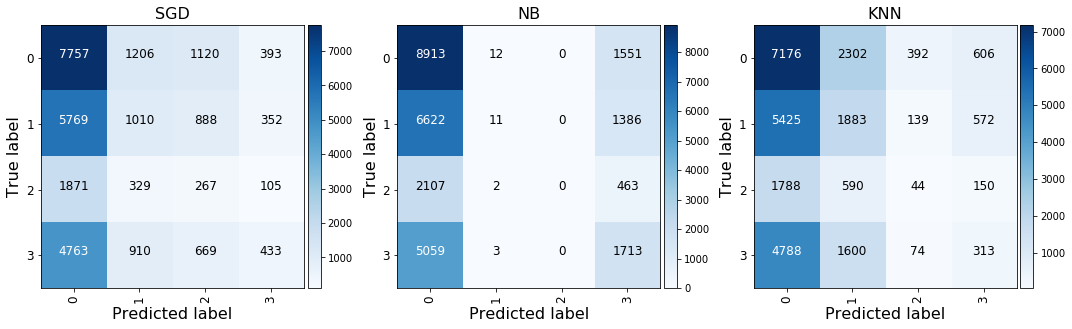

In [81]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
cm_plot(ax[0], range(len(encoder.categories_[0])), CM['sgd'], 'SGD', fig)
cm_plot(ax[1], range(len(encoder.categories_[0])), CM['nb'], 'NB', fig)
cm_plot(ax[2], range(len(encoder.categories_[0])), CM['knn'], 'KNN', fig)
plt.tight_layout()
plt.show()